In [1]:
from sqlalchemy import create_engine, text
import pandas as pd
from ml_experiments.analyze import get_df_runs_from_mlflow_sql, get_missing_entries, get_common_combinations, get_df_with_combinations
import plotly.express as px
from itertools import product
import time
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

# Save Results

## Load mlflow runs

In [5]:
db_port = 5001
db_name = 'cohirf'
w = 'clust9'
# url = f'postgresql://{w}.ceremade.dauphine.lan:{db_port}/{db_name}'
url = f'postgresql://beluccib@localhost:{db_port}/{db_name}'
engine = create_engine(url)
query = 'SELECT experiments.name from experiments'
experiment_names = pd.read_sql(query, engine)['name'].tolist()
# results_dir = Path('~/tab_benchmark/results')
# os.makedirs(results_dir, exist_ok=True)

In [6]:
experiment_names

['Default', 'classif_huge_cohirf']

In [7]:
experiments_names = [
    'classif_huge_cohirf',
]

In [22]:
params_columns = [
    'model_nickname',
    'n_samples',
    'n_features',
    'pct_random',
    'seed_unified',
    'class_sep',
    'n_random',
    'n_informative',
    'n_classes',
    'n_trials',
    'hpo_metric'
]

In [23]:
latest_metrics_columns = [
    'fit_model_return_elapsed_time',
    'max_memory_used',
    'n_clusters_',
    'rand_score',
    'adjusted_rand',
    'mutual_info',
    'adjusted_mutual_info',
    'normalized_mutual_info',
    'homogeneity',
    'completeness',
    'v_measure',
    'silhouette',
    'calinski_harabasz_score',
    'davies_bouldin_score',
    'inertia_score',
    'best_n_clusters_',
    'best_rand_score',
    'best_adjusted_rand',
    'best_mutual_info',
    'best_adjusted_mutual_info',
    'best_normalized_mutual_info',
    'best_homogeneity_completeness_v_measure',
    'best_silhouette',
    'best_calinski_harabasz_score',
    'best_davies_bouldin_score',
    'best_inertia_score',
    'best_homogeneity',
    'best_completeness',
    'best_v_measure',
]

In [24]:
tags_columns = [
    'raised_exception',
    'EXCEPTION',
    'parent_run_id',
    'best_child_run_id',
]

In [25]:
# parameters of each model, they are saved as tags for the parent run
parameters = {
    'RecursiveClustering': ['components_size', 'repetitions', 'kmeans_n_clusters'],
    'KMeans': ['n_clusters'],
    'HDBSCAN': ['min_cluster_size'],
    'DBSCAN': ['eps', 'min_samples'],
    'AffinityPropagation': ['damping'],
    'OPTICS': ['min_samples'],
    'SpectralSubspaceRandomization': ['n_similarities', 'sampling_ratio', 'sc_n_clusters'],
    'WardAgglomerativeClustering': ['n_clusters'],
}
all_model_parameters = [p for model, params in parameters.items() for p in params]
all_model_parameters = list(set(all_model_parameters))
for param in all_model_parameters:
    tags_columns.append(param)

In [26]:
runs_columns = ['run_uuid', 'status', 'start_time', 'end_time']
experiments_columns = []
other_table = 'params'
other_table_keys = params_columns
df_params = get_df_runs_from_mlflow_sql(engine, runs_columns=runs_columns, experiments_columns=experiments_columns, experiments_names=experiments_names, other_table=other_table, other_table_keys=other_table_keys)
df_latest_metrics = get_df_runs_from_mlflow_sql(engine, runs_columns=['run_uuid'], experiments_columns=experiments_columns, experiments_names=experiments_names, other_table='latest_metrics', other_table_keys=latest_metrics_columns)
df_tags = get_df_runs_from_mlflow_sql(engine, runs_columns=['run_uuid'], experiments_columns=experiments_columns, experiments_names=experiments_names, other_table='tags', other_table_keys=tags_columns)

In [27]:
df_runs_raw = df_params.join(df_latest_metrics)
df_runs_raw = df_runs_raw.join(df_tags)

In [28]:
df_runs_raw_parents = df_runs_raw.copy()
df_runs_raw_parents = df_runs_raw_parents.loc[df_runs_raw_parents['parent_run_id'].isna()]

In [29]:
df_runs_raw_parents

key,status,start_time,end_time,class_sep,hpo_metric,model_nickname,n_classes,n_features,n_informative,n_random,...,rand_score,silhouette,v_measure,EXCEPTION,best_child_run_id,components_size,kmeans_n_clusters,parent_run_id,raised_exception,repetitions
run_uuid,,,,,,,,,,,,,,,,,,,,,
00616980b4b3475a8551239feef4db72,FINISHED,1741108019629,1.741111e+12,30.0,adjusted_rand,RecursiveClustering,5,10000,None,None,...,0.920816,-0.003604,0.799672,NaN,e7b63704b871435a9c06b2421536411f,29,5,NaN,False,8
07657d46867440e594189497260ccea0,FINISHED,1741108032926,1.741111e+12,20.0,adjusted_rand,RecursiveClustering,5,10000,None,None,...,0.817159,-0.013495,0.485268,NaN,14f48d9551514ffb8360b57cea94fa05,27,5,NaN,False,4
08b0c324a88a49bcb118da0550160e2b,FINISHED,1741108003906,1.741112e+12,10.0,adjusted_rand,RecursiveClustering,5,10000,None,None,...,0.699588,-0.001944,0.056241,NaN,c9afba7a5ef74d4ea69be782e1242d3b,28,2,NaN,False,4
0b84663870924ef5bf5bb5a4a6dbf3d1,FINISHED,1741182334387,1.741189e+12,100.0,calinski_harabasz_score,RecursiveClustering,5,10000,None,None,...,0.954960,0.301966,0.902727,NaN,32fd45f3c12240279f68b144f977bfe4,19,5,NaN,False,3
0c83bda5646a47769a925eb7c3acaae6,FINISHED,1741108005481,1.741112e+12,30.0,adjusted_rand,RecursiveClustering,5,10000,None,None,...,0.874698,-0.008814,0.711464,NaN,8eb6d2ac53d7458f9c0b38f7c5d0fba7,29,5,NaN,False,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
f0cd4d8e29704b4ab449f5a945b46bac,FINISHED,1741182330702,1.741185e+12,20.0,calinski_harabasz_score,RecursiveClustering,5,10000,None,None,...,0.732347,-0.021651,0.124711,NaN,8d02ffd6d9484834927b804c42b0d855,15,2,NaN,False,3
f4591eb30ea642e28a73ec575048fdec,FINISHED,1741182333590,1.741188e+12,50.0,calinski_harabasz_score,RecursiveClustering,5,10000,None,None,...,0.988758,0.091251,0.963933,NaN,88e56d37aea04ce6b35511fa0a903a98,29,2,NaN,False,10
fac86d1d7cf042dc9a8f23c3d6ed4e09,FAILED,1741182336741,1.741184e+12,40.0,calinski_harabasz_score,RecursiveClustering,5,10000,None,None,...,0.966044,0.045986,0.901775,(sqlite3.OperationalError) database is locked\...,NaN,NaN,NaN,NaN,True,NaN


In [30]:
# Separate our method with two types n_trials
df_runs_parents = df_runs_raw_parents.copy()
df_runs_parents.loc[(df_runs_parents['model_nickname'] == 'RecursiveClustering') & (df_runs_parents['n_trials'] == '20'), 'model_nickname'] = 'RecursiveClustering_20'

## Delete duplicate runs (if any) and complete some models that cannot run with some datasets

In [31]:
non_duplicate_columns = [
    'model_nickname',
    'n_samples',
    'n_features',
    'pct_random',
    'seed_unified',
    'class_sep',
    'n_random',
    'n_informative',
    'n_classes',
    'hpo_metric'
]
df_runs_parents = df_runs_parents.dropna(axis=0, how='all', subset=['best_adjusted_rand']).copy()
df_runs_parents = df_runs_parents.loc[(~df_runs_parents.duplicated(non_duplicate_columns))]

# Missing

In [32]:
df_runs_parents['model_nickname'].unique().tolist()

['RecursiveClustering_20']

In [35]:
non_duplicate_columns = [
    'model_nickname',
    'n_samples',
    'n_features',
    'pct_random',
    'seed_unified',
    'class_sep',
    'hpo_metric',
]

In [36]:
n_samples = ['100000']
n_features = ['10000']
pct_random = ['0.0']
seed_unified = [f'{i}' for i in range(0)]
class_sep = ['10.0', '20.0', '30.0', '40.0', '50.0', '100.0']
model_nickname = [
    'RecursiveClustering_20',
]
hpo_metric = ['adjusted_rand', 'calinski_harabasz_score']
columns_names = non_duplicate_columns
should_contain_values = [model_nickname, n_samples, n_features, pct_random, seed_unified, class_sep, hpo_metric]
df_missing = get_missing_entries(df_runs_parents, columns_names, should_contain_values)

In [37]:
df_missing

,model_nickname,n_samples,n_features,pct_random,seed_unified,class_sep,hpo_metric


# Plots

In [46]:
df_plots = df_runs_parents.copy()
df_plots['n_samples'] = df_plots['n_samples'].astype(int)
df_plots['n_features'] = df_plots['n_features'].astype(int)
df_plots['pct_random'] = df_plots['pct_random'].astype(float)
df_plots['class_sep'] = df_plots['class_sep'].astype(float)

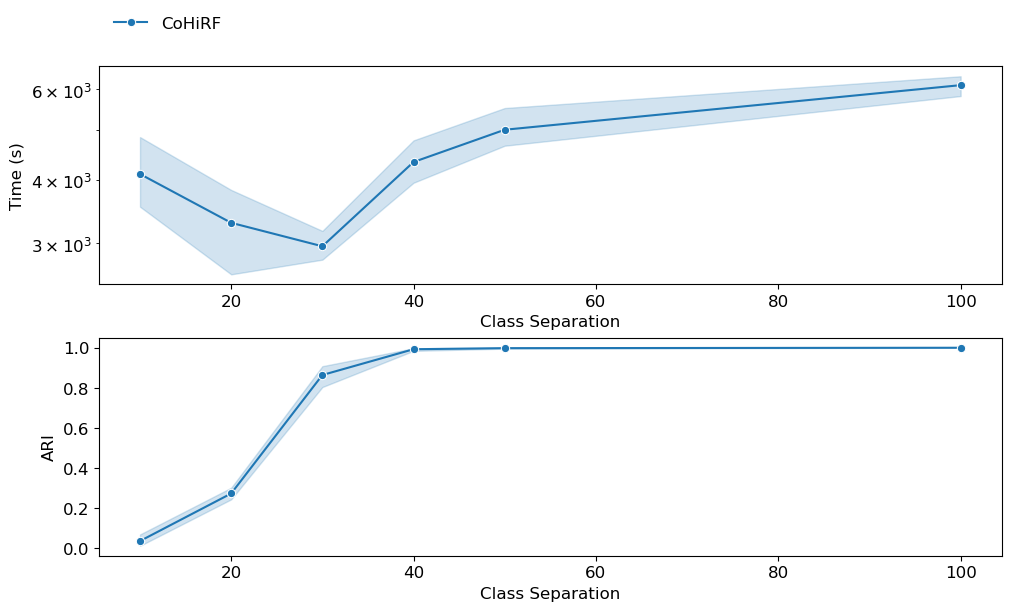

In [47]:
df = df_plots.copy()
n_features = 10000
n_samples = 100000
pct_random = 0.0
hpo_metric = 'adjusted_rand'
models_names = {
    # 'RecursiveClustering': 'CoHiRF',
    'RecursiveClustering_20': 'CoHiRF',
    'KMeans': 'K-Means',
    'HDBSCAN': 'HDBSCAN',
    'DBSCAN': 'DBSCAN',
    'AffinityPropagation': 'Affinity Propagation',
    'OPTICS': 'OPTICS',
    'SpectralSubspaceRandomization': 'SC-SRGF',
    'WardAgglomerativeClustering': "Ward's Method",
}
df = df.loc[df['pct_random']==pct_random]
df = df.loc[df['hpo_metric']==hpo_metric]
# df = df.loc[~df['class_sep'].isin([10, 20])]
# df = df.loc[df['model_nickname'].isin(['RecursiveClustering_20', 'KMeans', 'HDBSCAN', 'AffinityPropagation', 'OPTICS', 'SpectralSubspaceRandomization', 'WardAgglomerativeClustering'])]
df = df.replace({'model_nickname': models_names})
df = df.sort_values(by='model_nickname')
df = df.rename(columns={'fit_model_return_elapsed_time': 'Time (s)', 'max_memory_used': 'Memory (MB)', 'n_samples': 'Number of samples', 'n_features': 'Number of features', 'model_nickname': 'Model', 'class_sep': 'Class Separation', 'pct_random': '% Random Features', 'best_adjusted_rand' : 'ARI'})
plt.style.use('default')
# plt.style.use('seaborn-v0_8-paper')
with mpl.rc_context(rc={
    'figure.constrained_layout.use': True,
    'savefig.bbox': 'tight',
    'figure.figsize': (10, 6),
    'legend.loc': 'upper left',
    'legend.frameon': False,
    'font.size': 12,
    # 'font.family': 'serif',
    # 'font.serif': 'Times',
    'text.color': 'black',
    'grid.color': 'black',
    'grid.alpha': 0.5,
}):
    fig, axs = plt.subplots(2, 1)
    axs = axs.flatten()
    df_plot = df.copy()
    df_plot = df_plot.loc[df_plot['Number of features']==n_features]
    df_plot = df_plot.loc[df_plot['Number of samples']==n_samples]
    ax = sns.lineplot(data=df_plot, x='Class Separation', y='Time (s)', hue='Model', style='Model', markers=True, errorbar='ci', ax=axs[0])
    ax.legend().set_visible(False)
    ax.set_yscale('log')
    ax2 = sns.lineplot(data=df_plot, x='Class Separation', y='ARI', hue='Model', style='Model', markers=True, errorbar='ci', ax=axs[1])
    ax2.legend().set_visible(False)
    ax.legend(title=None, fontsize=12, bbox_to_anchor=(0.0, 1.3), ncols=4)
    plt.savefig(f'hypercube_n-samples{n_samples}_n-features{n_features}_pct-random{pct_random}_with_time.pdf')
    plt.show()
    # for i, (n_samples, n_features) in enumerate(n_samples_n_features):
    #     df_plot = df.copy()
    #     df_plot = df_plot.loc[df_plot['Number of features']==n_features]
    #     df_plot = df_plot.loc[df_plot['Number of samples']==n_samples]
    #     ax = sns.lineplot(data=df_plot, x='Class Separation', y='ARI', hue='Model', style='Model', markers=True, errorbar='ci', ax=axs[i])
    #     ax.legend().set_visible(False)
    #     # plt.legend(title=None, bbox_to_anchor=(0.6, 0.3))
        # plt.savefig(f'hypercube_n-samples{n_samples}_n-features{n_features}_pct-random{pct_random}.pdf')
        # plt.show()
# axs[0].legend(title=None, fontsize=12)

# plt.show()

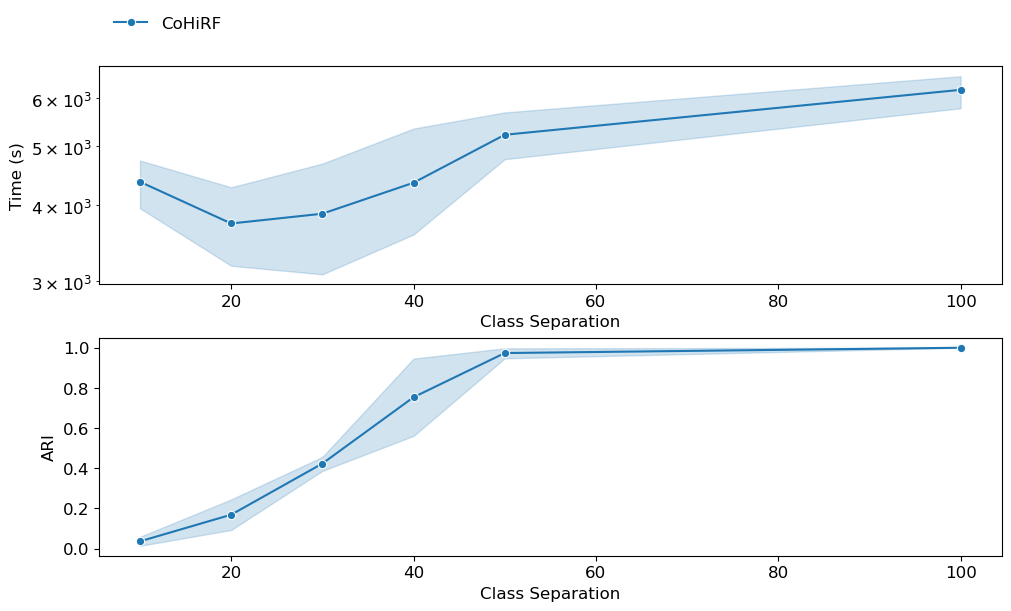

In [48]:
df = df_plots.copy()
n_features = 10000
n_samples = 100000
pct_random = 0.0
hpo_metric = 'calinski_harabasz_score'
models_names = {
    # 'RecursiveClustering': 'CoHiRF',
    'RecursiveClustering_20': 'CoHiRF',
    'KMeans': 'K-Means',
    'HDBSCAN': 'HDBSCAN',
    'DBSCAN': 'DBSCAN',
    'AffinityPropagation': 'Affinity Propagation',
    'OPTICS': 'OPTICS',
    'SpectralSubspaceRandomization': 'SC-SRGF',
    'WardAgglomerativeClustering': "Ward's Method",
}
df = df.loc[df['pct_random']==pct_random]
df = df.loc[df['hpo_metric']==hpo_metric]
# df = df.loc[~df['class_sep'].isin([10, 20])]
# df = df.loc[df['model_nickname'].isin(['RecursiveClustering_20', 'KMeans', 'HDBSCAN', 'AffinityPropagation', 'OPTICS', 'SpectralSubspaceRandomization', 'WardAgglomerativeClustering'])]
df = df.replace({'model_nickname': models_names})
df = df.sort_values(by='model_nickname')
df = df.rename(columns={'fit_model_return_elapsed_time': 'Time (s)', 'max_memory_used': 'Memory (MB)', 'n_samples': 'Number of samples', 'n_features': 'Number of features', 'model_nickname': 'Model', 'class_sep': 'Class Separation', 'pct_random': '% Random Features', 'best_adjusted_rand' : 'ARI'})
plt.style.use('default')
# plt.style.use('seaborn-v0_8-paper')
with mpl.rc_context(rc={
    'figure.constrained_layout.use': True,
    'savefig.bbox': 'tight',
    'figure.figsize': (10, 6),
    'legend.loc': 'upper left',
    'legend.frameon': False,
    'font.size': 12,
    # 'font.family': 'serif',
    # 'font.serif': 'Times',
    'text.color': 'black',
    'grid.color': 'black',
    'grid.alpha': 0.5,
}):
    fig, axs = plt.subplots(2, 1)
    axs = axs.flatten()
    df_plot = df.copy()
    df_plot = df_plot.loc[df_plot['Number of features']==n_features]
    df_plot = df_plot.loc[df_plot['Number of samples']==n_samples]
    ax = sns.lineplot(data=df_plot, x='Class Separation', y='Time (s)', hue='Model', style='Model', markers=True, errorbar='ci', ax=axs[0])
    ax.legend().set_visible(False)
    ax.set_yscale('log')
    ax2 = sns.lineplot(data=df_plot, x='Class Separation', y='ARI', hue='Model', style='Model', markers=True, errorbar='ci', ax=axs[1])
    ax2.legend().set_visible(False)
    ax.legend(title=None, fontsize=12, bbox_to_anchor=(0.0, 1.3), ncols=4)
    plt.savefig(f'hypercube_n-samples{n_samples}_n-features{n_features}_pct-random{pct_random}_with_time.pdf')
    plt.show()
    # for i, (n_samples, n_features) in enumerate(n_samples_n_features):
    #     df_plot = df.copy()
    #     df_plot = df_plot.loc[df_plot['Number of features']==n_features]
    #     df_plot = df_plot.loc[df_plot['Number of samples']==n_samples]
    #     ax = sns.lineplot(data=df_plot, x='Class Separation', y='ARI', hue='Model', style='Model', markers=True, errorbar='ci', ax=axs[i])
    #     ax.legend().set_visible(False)
    #     # plt.legend(title=None, bbox_to_anchor=(0.6, 0.3))
        # plt.savefig(f'hypercube_n-samples{n_samples}_n-features{n_features}_pct-random{pct_random}.pdf')
        # plt.show()
# axs[0].legend(title=None, fontsize=12)

# plt.show()

# Debug and explore

In [ ]:
df = df_runs_raw.copy()
df = df.loc[df['status'] == 'FAILED']

In [ ]:
df['EXCEPTION'].unique()

In [ ]:
df = df_runs_raw_parents.copy()
df = df.loc[df['status'] == 'FAILED']

In [ ]:
df

In [ ]:
parent_run_ids = list(df.index)

In [ ]:
parent_run_ids

In [ ]:
df = df_runs_raw.copy()
df = df.loc[df['parent_run_id'].isin(parent_run_ids)]

In [ ]:
child_run_ids = list(df.index)

In [ ]:
runs_to_delete = child_run_ids

In [ ]:
print(runs_to_delete, len(runs_to_delete))

In [ ]:
run_uuid_query = [f"'{run_id}'" for run_id in runs_to_delete]
run_uuid_query = ', '.join(run_uuid_query)

In [ ]:
query = f"""
UPDATE runs
SET lifecycle_stage = 'deleted'
WHERE run_uuid IN ({run_uuid_query}) 
"""
with engine.begin() as conn:
    conn.execute(text(query))

for i, row in df_runs_raw.iterrows():
    run_id = row.run_id
    model_name = row['params.model_name']
    with mlflow.start_run(run_id) as run:
        mlflow.log_param('model_nickname', model_name)    